In [1]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,AutoModelForMaskedLM , Trainer,TrainingArguments,BitsAndBytesConfig,pipeline,default_data_collator
from peft import get_peft_model,LoraConfig
import datasets
import torchmetrics
import torch
from hqq.engine.hf import HQQModelForCausalLM
from hqq.models.hf.base import AutoHQQHFModel
from huggingface_hub import snapshot_download
#import deepspeed
import os
import pandas as pd
import json
from var_dump import var_dump
from bs4 import BeautifulSoup

cache_dir='/proj/ciptmp/ix05ogym/.cache/'
output_dir = cache_dir+'outputs/'


/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No ROCm runtime is found, using ROCM_HOME='/usr'


In [2]:
KEYWORDS={
        #----------------------form--------------------------------------
       'firstname':['firstname','first_name','forename','first','first-name'],
       'lastname':['lastname','last_name','surename','last','last-name'] ,
       'email':['email','e-mail','username','user_name','user-name','type="email"'], 
       'password':['password'], 
       'cv':['cv','resume','curriculum','vitae'],
       'birthdate':['birthdate','birth','dateofbirth','date-of-birth','birth-date'],
       'phonenumber':['phonenumber','phone','telephone','tel'],
       'housenumber':['hausnummer'],
       'residentcountry':['resident','country'],
       'citizencountry':['citizen','citizenship','city'],
       'transcript':['transcript'],
       'coverletter':['coverletter','cover', 'letter'], 
       'picture':['picture'], 
       'address':['address','location'],
       'linkedin':['linkedin'],
       'github':['github'],
       'xing':['xing'],
       'twitter':['twitter'],
       'website':['website'],
       'postalcode':['postalcode','zip','zip-code','postal'],
       'city':['city'],
       'housenumber':['housenumber'], 
       'salary':['salary'],
       'sex':['sex','gender'], 
       'availablefrom':['noticeprieod'],
       'file':['type="file"'],
       'captcha':['captcha'],
       'submit':['apply','type="submit"'],
       'cancel':['cancel'],
       'fake':['fake'],
       'question':['question'],
       'agree':['agree'],
       'other':['other'],
       'apply':['apply'],
       'recommendation':['recommendation'],
       'workherebefore':['workherebefore'],
       'findus':['find'],
       'dropbox':['dropbox'],
       'googledrive':['google drive'],
       'workhours':['workhours'],
       'workduration':[''],
       'visa':['visa'],
       'eligible':['eligible'],
       'germanlevel':['germanlevel'],
       'company':[''],#current company
       'relocate':[''],
       'universityenrollment':[],#are a student?
       'englishlevel':[],
       #important about job
       #important about jobplace?
              
       #-------------------------------------------------------------------
       #-----------------------------------btns ---------------------------
       'login':['login','sign'],
       'username':['username'],
       'register':['register','sign'],
       'cookie':['cookie'],
       'next':['apply now','next'],
       'search':[],
       #-------------------------------------------------------------------
       
       
       
       
       }


LABEL_INDEX_TO_KEY = list(KEYWORDS.keys()) #self.personal_data.columns
i =0
LABEL_KEY_TO_INDEX = {}
for key in KEYWORDS:
            LABEL_KEY_TO_INDEX[key] =i
            i+=1 

In [3]:
mydata = pd.read_pickle('input_text.pkl')
#mydata.reset_index(inplace=True)
mydata

,text,element,label,input_text,labels
0,personal informationcv or resumebrowse cv to a...,"<input name=""cv"" accept=""application/pdf,.pdf""...",cv,personal informationcv or resumebrowse cv to a...,cv
1,"*<input data-testid=""textinput"" id=""email"" req...","<input data-testid=""textinput"" id=""email"" requ...",email,"<input data-testid=""textinput"" id=""email"" requ...",email
2,"*<input data-testid=""textinput"" id=""email"" req...","<input data-testid=""firstname"" id=""firstname"" ...",firstname,"*<input data-testid=""firstname"" id=""firstname""...",firstname
3,"*<input data-testid=""textinput"" id=""email"" req...","<input data-testid=""lastname"" id=""lastname"" re...",lastname,"*<input data-testid=""lastname"" id=""lastname"" r...",lastname
4,"*<input data-testid=""textinput"" id=""email"" req...","<input accept="".doc, .docx, .pdf, .rtf, .txt"" ...",firstname,"documents:.doc, .docx, .pdf, .rtf, .txt<input ...",cv
...,...,...,...,...,...
596,"business analyst (m/w/d)*<input type=""file"" si...","<a href=""https://vertriebskarriere.hansemerkur...",firstname,"upload fileprivacy policy<a href=""https://vert...",agree
597,"business analyst (m/w/d)*<input type=""file"" si...","<a href=""https://bewerber-innendienst.hansemer...",phonenumber,"back<a href=""https://bewerber-innendienst.hans...",cancel
598,"business analyst (m/w/d)*<input type=""file"" si...","<a href=""#"" onclick=""javascript: $(this).paren...",firstname,"send<a href=""#"" onclick=""javascript: $(this).p...",submit
599,"<input type=""email"" name=""email"" placeholder=""...","<input type=""email"" name=""email"" placeholder=""...",email,"input type=""email"" name=""email"" placeholder=""y...",email


<Axes: xlabel='labels'>

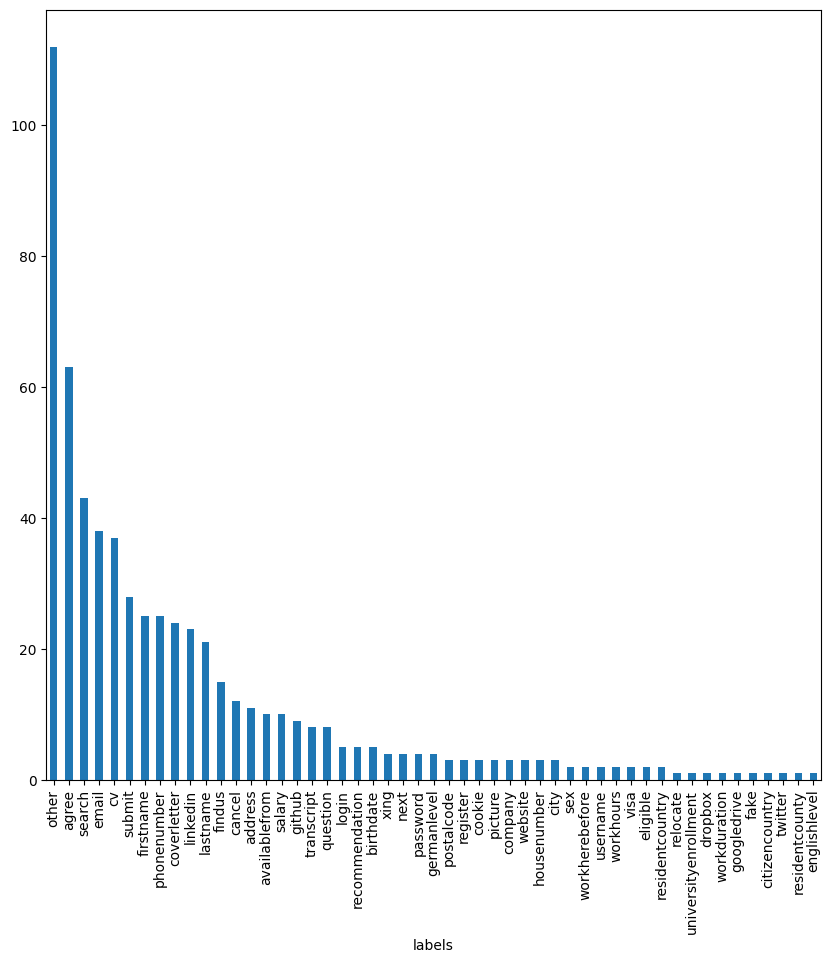

In [4]:
mydata['labels'].value_counts().plot(figsize=(10,10), kind='bar')

In [5]:
mydata[mydata['labels']=='residentcounty']#='residentcountry'
mydata.loc[45,'labels'] = 'residentcountry'

In [6]:
"""index = (inp['input_ids']== toknizer.mask_token_id).int().argmax().item()
print(index ,o.logits.shape)
token_id = o.logits[0,index,:].argsort(descending=True)
r = toknizer.convert_ids_to_tokens(token_id[:5])
MASK = toknizer.convert_tokens_to_string(r[0:1])
"""

"index = (inp['input_ids']== toknizer.mask_token_id).int().argmax().item()\nprint(index ,o.logits.shape)\ntoken_id = o.logits[0,index,:].argsort(descending=True)\nr = toknizer.convert_ids_to_tokens(token_id[:5])\nMASK = toknizer.convert_tokens_to_string(r[0:1])\n"

In [7]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large-mnli" , cache_dir=cache_dir)
model  = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-large-mnli",
                          #quantization_config=GPTQConfig(bits=4, disable_exllama=False),
                          #load_in_8bit=True,
                          num_labels=3,
                          cache_dir=cache_dir).half()

#model = get_peft_model(model,LoraConfig(task_type= 'SEQ_CLS',target_modules =['out_proj']))
#model.print_trainable_parameters()
for n, p in model.named_parameters():
    if 'out_proj' not in n:
        p.requires_grad = False

# Check which parameters are still trainable
for n, p in model.named_parameters():
    if p.requires_grad:
        print(f'{n} {p.shape}')
model

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


classifier.out_proj.weight torch.Size([3, 1024])
classifier.out_proj.bias torch.Size([3])


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [8]:
data = datasets.Dataset.from_pandas(mydata)
data = data.train_test_split(0.2)
train_dataset = data['train']
test_dataset = data['test']

#print(len(test_dataset),len(test_dataset['labels']))
def preprocess(example):
    #print(example['element'])
    h = []
    p = []
    l = []
    #print(example['labels'])
    
    for i in range(len(example['labels'])):
        #print(i,len(example['labels']))
        for key in KEYWORDS.keys():
            if key==example['labels'][i]:
                #print(key,example['labels'][i])
                l.append(2)
            else:
                l.append(0)
                
                
            
            h.append(f"this text is about {key}.")
            p.append(example['element'][i])
            
    #h = [f"this text is about {i} ." for i in example['text']]
 
        
        
    #t = tokenizer(p,h,return_tensors='pt' , padding=True,truncation=True ,max_length=512).to('cuda')
    example['p'] = p
    example['h'] = h
    example['label'] = l
    return example

def pretok(example):
    
    x = tokenizer(example['p'],example['h'],return_tensors='pt' , padding=False,truncation=True ,max_length=512)
    x['input_ids'] = x['input_ids'][0]
    x['attention_mask'] = x['attention_mask'][0]
    return x
"""def preprocess(example):
    #print(example['element'])
    h = [f"this text is about {i} ." for i in example['text']]
    t= tokenizer(example['element'],h,return_tensors='pt' , padding=True,truncation=True ,max_length=512).to('cuda')
    t['labels'] = [1 for i in example['labels']]
    return t"""

train_dataset_tokenized =  train_dataset.map(preprocess,batch_size=32,batched=True,drop_last_batch=False,remove_columns=['text', 'element', 'labels', 'input_text'])
test_dataset_tokenized =  test_dataset.map(preprocess,batch_size=32,batched=True,drop_last_batch=False,remove_columns=['text', 'element', 'labels', 'input_text'])

train_dataset_tokenized

Map: 100%|██████████| 121/121 [00:00<00:00, 44502.87 examples/s]


Dataset({
    features: ['label', 'p', 'h'],
    num_rows: 480
})

In [9]:
train_dataset_tokenized =  train_dataset_tokenized.map(pretok,batch_size=32,batched=False,drop_last_batch=False,remove_columns=['p', 'h'])
test_dataset_tokenized =  test_dataset_tokenized.map(pretok,batch_size=32,batched=False,drop_last_batch=False,remove_columns=['p', 'h'])


test_dataset_tokenized


Map: 100%|██████████| 121/121 [00:00<00:00, 5975.57 examples/s]


Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 121
})

In [10]:
def f(x):

    
    return x
#test_dataset_tokenized = test_dataset_tokenized.map(f) 


In [11]:
len(test_dataset_tokenized['input_ids'][2])

105

In [12]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,max_length=512)
s = data_collator(test_dataset_tokenized[0:8])
s

/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'input_ids': tensor([[    0, 41552, 46797,  ...,     1,     1,     1],
        [    0, 41552, 29015,  ...,     1,     1,     1],
        [    0, 41552,   102,  ...,     1,     1,     1],
        ...,
        [    0, 41552, 46797,  ...,     1,     1,     1],
        [    0, 41552, 46797,  ...,  2170,     4,     2],
        [    0, 41552, 46797,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2])}

In [13]:
print(train_dataset['label'][0])
tokenizer.convert_tokens_to_string( tokenizer.convert_ids_to_tokens( train_dataset_tokenized[32]['input_ids'] ) )
#train_dataset_tokenized[2]['labels']

firstname


'<s><input type="submit" name="commit" value="log in" class="button bg-orange fnt-sans-semi-bold clr-white fnt-size-16 pad-10 expand hvr-opacity" data-disable-with="log in"></s></s>this text is about submit.</s>'

In [14]:
train_dataset_tokenized[0]

{'label': 2,
 'input_ids': [0,
  41552,
  46797,
  1907,
  40635,
  15954,
  8304,
  113,
  1380,
  40635,
  26296,
  29,
  12,
  3899,
  12,
  15954,
  30529,
  46797,
  113,
  766,
  40635,
  1215,
  642,
  1343,
  1215,
  996,
  6405,
  29899,
  113,
  13561,
  40635,
  1215,
  642,
  1343,
  1215,
  996,
  6405,
  29899,
  12,
  245,
  24083,
  1360,
  113,
  923,
  40635,
  245,
  24083,
  1360,
  46479,
  2,
  2,
  9226,
  2788,
  16,
  59,
  2854,
  4,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [15]:
#train_dataset_tokenized['labels'][1]

In [29]:
import torchmetrics
import numpy as np
from var_dump import var_dump
from transformers import DefaultDataCollator

def compute_metric(inp):
    preds , label_ids  = inp
    print(preds.shape)
    
    preds = torch.tensor(preds)
    label_ids = torch.tensor(label_ids)
    
    p_label = preds.argmax(1)
    
    for p,l in zip(p_label,label_ids):
        print(p,l)
        break
    metric = torchmetrics.Accuracy('multiclass',num_classes=3)
    acc = metric(p_label , label_ids )
    print(acc)
    return {'acc':acc}


batch_size = 128
trainer =  Trainer(
    model=model,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized,
    compute_metrics=compute_metric,
    #data_collator=data_collator, #DataCollatorWithPadding(tokenizer),
    tokenizer= tokenizer,
    
    args= TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        bf16=True,
        learning_rate=1e-4,
        optim='adafactor',
        
        
        
        
    )
    
)




print(trainer.evaluate(train_dataset_tokenized))
print(trainer.evaluate())

trainer.train()

(480, 3)
tensor(1) tensor(2)
tensor(0.6854)
{'eval_loss': 0.9522534608840942, 'eval_acc': 0.6854166388511658, 'eval_runtime': 4.2095, 'eval_samples_per_second': 114.029, 'eval_steps_per_second': 0.95}
(121, 3)
tensor(2) tensor(2)
tensor(0.6529)
{'eval_loss': 1.0261553525924683, 'eval_acc': 0.6528925895690918, 'eval_runtime': 0.7809, 'eval_samples_per_second': 154.95, 'eval_steps_per_second': 1.281}


Step,Training Loss


TrainOutput(global_step=40, training_loss=0.5146239757537842, metrics={'train_runtime': 53.9104, 'train_samples_per_second': 89.037, 'train_steps_per_second': 0.742, 'total_flos': 2768602697811264.0, 'train_loss': 0.5146239757537842, 'epoch': 10.0})

In [30]:
trainer.evaluate()

(121, 3)
tensor(2) tensor(2)
tensor(0.8430)


{'eval_loss': 0.5682231187820435,
 'eval_acc': 0.8429751992225647,
 'eval_runtime': 0.8084,
 'eval_samples_per_second': 149.683,
 'eval_steps_per_second': 1.237,
 'epoch': 10.0}

In [ ]:
model.classifier.out_proj.weight

Parameter containing:
tensor([[ 0.0154, -0.0114,  0.0045,  ..., -0.0197, -0.0067,  0.0116],
        [-0.0086, -0.0055, -0.0196,  ...,  0.0327, -0.0123,  0.0139],
        [ 0.0086,  0.0144, -0.0011,  ...,  0.0209,  0.0054, -0.0222]],
       device='cuda:0', dtype=torch.float16, requires_grad=True)

In [31]:
n = 0
ds = train_dataset
for i in range(len(ds)):
    y = preprocess(ds[i:i+1])
    x = tokenizer(y['p'],y['h'],return_tensors='pt' , padding=True,truncation=True ,max_length=512).to('cuda')
    #print(y.keys())
    with torch.no_grad():
        o = model(**x)
        index = o.logits[:,2].argmax(0)
        if LABEL_INDEX_TO_KEY[index]==y['labels'][0]:
            n+=1
            
        

    #break
    
n/len(ds)

0.04583333333333333

In [ ]:
$$$
for batch in trainer.get_train_dataloader():
    break
trainer.model.to('cuda')
batch = {k: v.to('cuda') for k, v in batch.items()}
trainer.create_optimizer()
#print(batch)
for _ in range(20):
    outputs = trainer.model(**batch)
    loss = outputs.loss
    print(loss)
    loss.backward()
    print(model.classifier.out_proj.weight.grad)
    print(model.classifier.out_proj.bias.grad)
    
    trainer.optimizer.step()
    print('-------------------------------------------------')
    print(model.classifier.out_proj.weight.grad)
    
    trainer.optimizer.zero_grad()
    #break


SyntaxError: invalid syntax (2147963413.py, line 1)

In [ ]:
"""bid = json.loads(d['actions'][1]['pos_candidates'][0]['attributes'])['backend_node_id']
print(d['actions'][1]['pos_candidates'])
soup = BeautifulSoup(lll['html'][1])#d['actions'][1]['raw_html'])
#soup = BeautifulSoup(d['actions'][3]['raw_html'])
#s = soup.find( '*' )
# Find all 'div' tags
soup = soup.find('form')
all_tags = soup.find_all()

# Remove all tags except for 'link', 'input', and 'select' tags
i=0
for element in all_tags:
    if element.name  in ['div','text']: 
    #if element.name not in ['a','link', 'input', 'select','radio','button']:
        
        element.unwrap()
    else:
        element['backend_node_id']=i
        
        if 'class' in element.attrs:
            del element['class']
            pass
        if 'bounding_box_rect' in element.attrs:
            del element['bounding_box_rect']
            pass
        if 'is_clickable' in element.attrs:
            del element['is_clickable']
            pass
        
            
        i+=1

     

s = soup.prettify()
#b = s.split("/>")
x = toknizer(s,return_tensors='pt')
print(x['input_ids'].shape[1],x['input_ids'].shape[1]/16348)


print(s)
if False:
    for i in b:
        print(i)
        print('---------------------')
"""

In [ ]:
from IPython.display import display, HTML
display(HTML(s))


In [ ]:
display(HTML(s))


In [ ]:
mydata.iloc[1,:]